In [7]:
import pyarrow.parquet as pq
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, History

In [8]:
print(help(History))

Help on class History in module keras.callbacks:

class History(Callback)
 |  Callback that records events into a `History` object.
 |  
 |  This callback is automatically applied to
 |  every Keras model. The `History` object
 |  gets returned by the `fit` method of models.
 |  
 |  Example:
 |  
 |  >>> model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
 |  >>> model.compile(tf.keras.optimizers.SGD(), loss='mse')
 |  >>> history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5),
 |  ...                     epochs=10)
 |  >>> print(history.params)
 |  {'verbose': 1, 'epochs': 10, 'steps': 1}
 |  >>> # check the keys of history object
 |  >>> print(history.history.keys())
 |  dict_keys(['loss'])
 |  
 |  Method resolution order:
 |      History
 |      Callback
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  on_epoch_end(self, epoch, logs=None)
 |      Called

In [11]:
df = pd.read_parquet("/Users/oguzguzel/Downloads/Skim.parquet")

In [12]:
df["label"] = 0
df = df[df['weight']>0 ]

In [13]:
print(df)

        weight  nTaus  nElecs  nMuons  nJets  nBJets       metPt  L_pt_mgg  \
0     0.004969      2       0       0      1       0  277.777344  1.730871   
1     0.004969      2       0       0      2       0   41.169174  0.565211   
2     0.004969      2       0       0      0       0   95.708366  1.139237   
3     0.004969      2       0       0      0       0  172.764420  1.754933   
4     0.004969      2       0       0      4       0   20.493635  1.144369   
..         ...    ...     ...     ...    ...     ...         ...       ...   
12    0.315751      2       0       0      4       1   92.576294  0.587197   
13    0.315751      2       0       0      5       1  201.621170  1.061145   
0   136.737015      2       0       0      2       0   62.564461  0.391133   
1   136.737015      2       0       0      5       0   52.317863  0.575433   
2   136.737015      2       0       0      4       3   78.190186  0.615140   

    L_photon_eta  L_photon_ID  ...  diP_pt_mgg    diP_DR   diP_

In [14]:
#df = df[~df.process.str.contains("QCD")]
#df = df[~df.process.str.contains("GluGluHToGG")]
#df = df[~df.process.str.contains("VBFToGG")]
#df = df[~df.process.str.contains("TTWJets")]
#df = df[~df.process.str.contains("TTGG_0Jets_")]
#df = df[~df.process.str.contains("TTGamma")]
#df = df[~df.process.str.contains("WW_Tune")]
#df = df[~df.process.str.contains("THQ_ctc")]
#df = df[~df.process.str.contains("W1Jets")]
#df = df[~df.process.str.contains("W2Jets")]
#df = df[~df.process.str.contains("W3Jets")]



#df.to_csv("dataframe_HHWWgg_withoutDY.csv")

In [15]:
df.loc[df.process.str.contains("HHH"), ['label']] = 1

In [16]:
batch_size = 128


def checkBatches(df):
    N_checks = 1000
    sum_sig = 0.
    N_sig = 0
    sum_back = 0.
    N_back = 0
    for i in range(N_checks):
        rnd_df = df.sample(batch_size)
        sum_sig  += rnd_df[rnd_df['label']==1]['weight'].sum()
        sum_back += rnd_df[rnd_df['label']==0]['weight'].sum()
        N_sig    += rnd_df[rnd_df['label']==1].shape[0]
        N_back   += rnd_df[rnd_df['label']==0].shape[0]
    sum_sig  /= N_checks
    sum_back /= N_checks
    N_sig    /= N_checks
    N_back   /= N_checks

    print (f'On average, per batch the total learning weight is\n\t... signal     : {sum_sig:12.6f} [{N_sig} events] \n\t... background : {sum_back:12.6f} [{N_back} events]')



In [17]:
checkBatches(df)

On average, per batch the total learning weight is
	... signal     :     0.889779 [123.221 events] 
	... background :    89.236796 [4.779 events]


In [18]:
print(df)

        weight  nTaus  nElecs  nMuons  nJets  nBJets       metPt  L_pt_mgg  \
0     0.004969      2       0       0      1       0  277.777344  1.730871   
1     0.004969      2       0       0      2       0   41.169174  0.565211   
2     0.004969      2       0       0      0       0   95.708366  1.139237   
3     0.004969      2       0       0      0       0  172.764420  1.754933   
4     0.004969      2       0       0      4       0   20.493635  1.144369   
..         ...    ...     ...     ...    ...     ...         ...       ...   
12    0.315751      2       0       0      4       1   92.576294  0.587197   
13    0.315751      2       0       0      5       1  201.621170  1.061145   
0   136.737015      2       0       0      2       0   62.564461  0.391133   
1   136.737015      2       0       0      5       0   52.317863  0.575433   
2   136.737015      2       0       0      4       3   78.190186  0.615140   

    L_photon_eta  L_photon_ID  ...  diP_pt_mgg    diP_DR   diP_

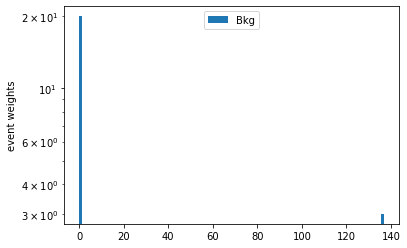

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
plt.hist(df.loc[df['label']==0,'weight'],bins=100,label='Bkg')
plt.yscale('log') 
plt.ylabel('event weights')
#plt.ylabel('')
#plt.title('dnn_score')
plt.legend(loc='upper center')
fig.savefig("event_weights_B.pdf", dpi = 300)



In [20]:
HHsum_weighted = df[df['label']==1]['weight'].sum()
print(HHsum_weighted)
HHsum_unweighted = 614702.0
bckgsum_weighted = df[df['label']==0]['weight'].sum() 
print(bckgsum_weighted)
classweight_Target = HHsum_unweighted

lumi = 3000

xsec_HH_2G2Tau = 0.00104441

HH_2G2Tau_sum_weighted = df[df['label']==1]['weight'].sum()

xsec_HH_2G2Qlnu = 0.0156981

xsec_HH_2G2l2nu = 0.0037234

xsec_VBF = 9.51216
VBF_sum_weighted = df[df.process.str.contains("VBF")]['weight'].sum()

xsec_ttH = 1.393764
ttH_sum_weighted = df[df.process.str.contains("ttH")]['weight'].sum()

xsec_GGH = 114.798
GGH_sum_weighted = df[df.process.str.contains("GGHToGG")]['weight'].sum()

xsec_VH = 5.44326
VH_sum_weighted = df[df.process.str.contains("VH")]['weight'].sum()

xsec_TTGG_0Jets = 18.64
TTGG_0Jets_sum_weighted = df[df.process.str.contains("TTGG_0Jets")]['weight'].sum()

xsec_TT_Tune = 864400 
TT_Tune_sum_weighted = df[df.process.str.contains("TT_Tune")]['weight'].sum()

xsec_TTGamma_Dilept = 623.1
TTGamma_Dilept_sum_weighted = df[df.process.str.contains("TTGamma_Dilept")]['weight'].sum()

xsec_TTGamma_Hadronic = 799
TTGamma_Hadronic_sum_weighted = df[df.process.str.contains("TTGamma_Hadronic")]['weight'].sum()

xsec_TTGamma_SingleLeptFromT = 770.9 
TTGamma_SingleLeptFromT_sum_weighted = df[df.process.str.contains("SingleLeptFromT")]['weight'].sum()

xsec_TTGamma_SingleLeptFromTbar = 769
TTGamma_SingleLeptFromTbar_sum_weighted = df[df.process.str.contains("SingleLeptFromTbar")]['weight'].sum()

xsec_GJet40toInf = 998100 
GJet40toInf_sum_weighted = df[df.process.str.contains("GJet_Pt-40toInf")]['weight'].sum()

xsec_GJet20to40 = 260850
GJet20to40_sum_weighted = df[df.process.str.contains("GJet_Pt-20to40")]['weight'].sum()

xsec_GJet20toInf = 3901000
GJet20toInf_sum_weighted = df[df.process.str.contains("GJet_Pt-20toInf")]['weight'].sum()

xsec_DiPhoton80toInf = 98670
DiPhoton80toInf_sum_weighted = df[df.process.str.contains("DiPhotonJetsBox_MGG-80toInf")]['weight'].sum()

xsec_DiPhoton40to80 = 332804
DiPhoton40to80_sum_weighted = df[df.process.str.contains("DiPhotonJetsBox_MGG-40to80")]['weight'].sum()

xsec_WGToLNuG = 18790
WGToLNuG_sum_weighted = df[df.process.str.contains("WGToLNuG")]['weight'].sum()

xsec_ZGTo2LG = 145200
ZGTo2LG_sum_weighted = df[df.process.str.contains("ZGTo2LG")]['weight'].sum()



print (f"Sum of learning weight for signal     = {df[df['label']==1]['weight'].sum():15.5f}")
print (f"Sum of learning weight for background = {df[df['label']==0]['weight'].sum():15.5f}")

# We divide by their sum, and multiply by the number of events
#   First part is so that the sum of weights of the signal is now == to the background ones
#   The second part is because if the weights are super small, the loss will be small
#       In practice the magnitude does not matter, only relative difference, but it is easier
#       to check the learning when the loss variations are not far in the decimals
#       -> like that the average unit weight is 1

df.loc[df['label']==1, 'scale'] = lumi * xsec_HH_2G2Tau / HH_2G2Tau_sum_weighted

df.loc[df.process.str.contains("GluGluHToGG"), 'scale'] = lumi * xsec_GGH/ GGH_sum_weighted
df.loc[df.process.str.contains("VBF"), 'scale'] = lumi * xsec_VBF/ VBF_sum_weighted
df.loc[df.process.str.contains("ttH"), 'scale'] = lumi * xsec_ttH/ ttH_sum_weighted
df.loc[df.process.str.contains("VH"), 'scale'] = lumi * xsec_VH/ VH_sum_weighted
df.loc[df.process.str.contains("TTGG_0Jets"), 'scale'] = lumi * xsec_TTGG_0Jets/ TTGG_0Jets_sum_weighted
df.loc[df.process.str.contains("TT_Tune"), 'scale'] = lumi * xsec_TT_Tune/ TT_Tune_sum_weighted
df.loc[df.process.str.contains("TTGamma_Dilept"), 'scale'] = lumi * xsec_TTGamma_Dilept/ TTGamma_Dilept_sum_weighted
df.loc[df.process.str.contains("TTGamma_Hadronic"), 'scale'] = lumi * xsec_TTGamma_Hadronic/ TTGamma_Hadronic_sum_weighted
df.loc[df.process.str.contains("TTGamma_SingleLeptFromT"), 'scale'] = lumi * xsec_TTGamma_SingleLeptFromT/ TTGamma_SingleLeptFromT_sum_weighted
df.loc[df.process.str.contains("TTGamma_SingleLeptFromTbar"), 'scale'] = lumi * xsec_TTGamma_SingleLeptFromTbar/ TTGamma_SingleLeptFromTbar_sum_weighted
df.loc[df.process.str.contains("GJet_Pt-40toInf"), 'scale'] = lumi * xsec_GJet40toInf/ GJet20to40_sum_weighted
df.loc[df.process.str.contains("GJet_Pt-20to40"), 'scale'] = lumi * xsec_GJet20to40/ GJet20to40_sum_weighted
df.loc[df.process.str.contains("GJet_Pt-20toInf"), 'scale'] = lumi * xsec_GJet20toInf/ GJet20toInf_sum_weighted
df.loc[df.process.str.contains("DiPhotonJetsBox_MGG-80toInf"), 'scale'] = lumi * xsec_DiPhoton80toInf/ DiPhoton80toInf_sum_weighted
df.loc[df.process.str.contains("DiPhotonJetsBox_MGG-40to80"), 'scale'] = lumi * xsec_DiPhoton40to80/ DiPhoton40to80_sum_weighted
df.loc[df.process.str.contains("ZGTo2LG"), 'scale'] = lumi * xsec_ZGTo2LG/ ZGTo2LG_sum_weighted


df["trainingweights"] = df.loc[:,'scale']*df.loc[:,'weight']

df.loc[df['label']==1,'trainingweights'] *= df.shape[0]/2 / df[df['label']==1]['trainingweights'].sum() 
df.loc[df['label']==0,'trainingweights'] *= df.shape[0]/2 / df[df['label']==0]['trainingweights'].sum()

print ("After equalization")
#print (f"Sum of learning weight for signal     = {df[df['label']==1]['weight'].sum():15.5f}")
#print (f"Sum of learning weight for background = {df[df['label']==0]['weight'].sum():15.5f}")
print (f"Sum of learning weight for signal     = {df[df['label']==1]['trainingweights'].sum():15.5f}")
print (f"Sum of learning weight for background = {df[df['label']==0]['trainingweights'].sum():15.5f}")

print (f'Average learning weight = {df["trainingweights"].mean()}')

print ('\nNow let us try again with batches')
#checkBatches(df)

4.32166775290171
415.2542901007865
Sum of learning weight for signal     =         4.32167
Sum of learning weight for background =       415.25429
After equalization
Sum of learning weight for signal     =       309.50000
Sum of learning weight for background =       309.50000
Average learning weight = 1.0

Now let us try again with batches


/var/folders/53/fsl9_lm107j607621qgqc8cw0000gn/T/ipykernel_3967/1609238217.py:83: RuntimeWarning: divide by zero encountered in double_scalars
  df.loc[df.process.str.contains("GluGluHToGG"), 'scale'] = lumi * xsec_GGH/ GGH_sum_weighted
/var/folders/53/fsl9_lm107j607621qgqc8cw0000gn/T/ipykernel_3967/1609238217.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  df.loc[df.process.str.contains("VBF"), 'scale'] = lumi * xsec_VBF/ VBF_sum_weighted
/var/folders/53/fsl9_lm107j607621qgqc8cw0000gn/T/ipykernel_3967/1609238217.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  df.loc[df.process.str.contains("TT_Tune"), 'scale'] = lumi * xsec_TT_Tune/ TT_Tune_sum_weighted
/var/folders/53/fsl9_lm107j607621qgqc8cw0000gn/T/ipykernel_3967/1609238217.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  df.loc[df.process.str.contains("TTGamma_Dilept"), 'scale'] = lumi * xsec_TTGamma_Dilept/ TTGamma_Dilept_sum_weighted
/var/folders/53/fsl9_lm107j6076

In [21]:
batch_size = 128


def checkBatches_X(df):
    N_checks = 1000
    sum_sig = 0.
    N_sig = 0
    sum_back = 0.
    N_back = 0
    for i in range(N_checks):
        rnd_df = df.sample(batch_size)
        sum_sig  += rnd_df[rnd_df['label']==1]['trainingweights'].sum()
        sum_back += rnd_df[rnd_df['label']==0]['trainingweights'].sum()
        N_sig    += rnd_df[rnd_df['label']==1].shape[0]
        N_back   += rnd_df[rnd_df['label']==0].shape[0]
    sum_sig  /= N_checks
    sum_back /= N_checks
    N_sig    /= N_checks
    N_back   /= N_checks

    print (f'On average, per batch the total learning weight is\n\t... signal     : {sum_sig:12.6f} [{N_sig} events] \n\t... background : {sum_back:12.6f} [{N_back} events]')


checkBatches_X(df)

On average, per batch the total learning weight is
	... signal     :    63.776386 [123.217 events] 
	... background :    61.996623 [4.783 events]


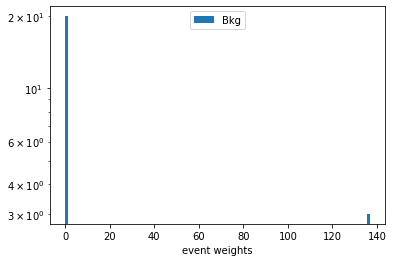

In [22]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(df.loc[df['label']==0,'weight'],bins=100,label='Bkg')
plt.yscale('log') 
plt.xlabel('event weights')
#plt.ylabel('')
#plt.title('dnn_score')
plt.legend(loc='upper center')
fig.savefig("event_weights_A.pdf", dpi = 300)

In [23]:
input_vars=["nTaus",
            "nElecs",
            "nMuons",
            "nJets",
            "nBJets",
            "metPt",
            "L_pt_mgg",
            "L_photon_eta",
            "L_photon_ID",
            "SL_pt_mgg",
            "SL_photon_eta",
            "SL_photon_ID",
            "diP_pt_mgg",
            "diP_DR",
            "diP_Phi",
            "DRtautau",
            "DPhitautau",
            "Mtautau",
            "pTtautau",
            "met"
]

In [24]:
print(df[input_vars])

    nTaus  nElecs  nMuons  nJets  nBJets       metPt  L_pt_mgg  L_photon_eta  \
0       2       0       0      1       0  277.777344  1.730871      0.186709   
1       2       0       0      2       0   41.169174  0.565211     -1.028125   
2       2       0       0      0       0   95.708366  1.139237     -1.884565   
3       2       0       0      0       0  172.764420  1.754933      0.466384   
4       2       0       0      4       0   20.493635  1.144369     -0.439785   
..    ...     ...     ...    ...     ...         ...       ...           ...   
12      2       0       0      4       1   92.576294  0.587197     -0.346127   
13      2       0       0      5       1  201.621170  1.061145      0.015613   
0       2       0       0      2       0   62.564461  0.391133     -2.020563   
1       2       0       0      5       0   52.317863  0.575433     -0.931661   
2       2       0       0      4       3   78.190186  0.615140      1.831455   

    L_photon_ID  SL_pt_mgg  SL_photon_e

In [25]:
#df_clean = df[input_vars].copy()
#df_clean["label"] = df.loc[:,"label"]
#df_clean.to_csv("dataframe_HHWWgg.csv")
print(df)

        weight  nTaus  nElecs  nMuons  nJets  nBJets       metPt  L_pt_mgg  \
0     0.004969      2       0       0      1       0  277.777344  1.730871   
1     0.004969      2       0       0      2       0   41.169174  0.565211   
2     0.004969      2       0       0      0       0   95.708366  1.139237   
3     0.004969      2       0       0      0       0  172.764420  1.754933   
4     0.004969      2       0       0      4       0   20.493635  1.144369   
..         ...    ...     ...     ...    ...     ...         ...       ...   
12    0.315751      2       0       0      4       1   92.576294  0.587197   
13    0.315751      2       0       0      5       1  201.621170  1.061145   
0   136.737015      2       0       0      2       0   62.564461  0.391133   
1   136.737015      2       0       0      5       0   52.317863  0.575433   
2   136.737015      2       0       0      4       3   78.190186  0.615140   

    L_photon_eta  L_photon_ID  ...   diP_Phi  DRtautau  DPhitau

In [26]:
X_train, X_test, y_train, y_test,w_train, w_test = train_test_split(df[input_vars], df.label, df.trainingweights, 
                                                    test_size=0.50, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(df[input_vars], df.label, test_size=0.50, random_state=42)

In [27]:
print(X_train)

     nTaus  nElecs  nMuons  nJets  nBJets       metPt  L_pt_mgg  L_photon_eta  \
7        2       0       0      2       0  154.945770  1.110334     -1.216731   
263      2       0       0      1       0  159.870956  1.459129     -0.201024   
50       2       0       0      1       0   43.457371  0.648681      0.507554   
229      2       0       0      2       0   34.492573  0.645732      0.296542   
37       2       0       0      1       0   67.543373  0.764116      0.396836   
..     ...     ...     ...    ...     ...         ...       ...           ...   
71       2       0       0      0       0   62.587887  0.658660      0.414380   
106      2       0       0      2       0  108.906670  0.826785     -0.421609   
270      2       0       0      1       0   98.883987  1.519780     -0.835539   
435      2       0       0      0       0   40.723377  0.831767      0.169305   
102      2       0       0      2       0   87.447044  0.897256     -1.889914   

     L_photon_ID  SL_pt_mgg

In [28]:
print(X_test)

     nTaus  nElecs  nMuons  nJets  nBJets       metPt  L_pt_mgg  L_photon_eta  \
49       2       0       0      3       1  157.071915  1.397709      0.104354   
7        2       0       0      1       0   52.206760  0.525109      0.744755   
82       2       0       0      1       0   86.869926  0.451269      0.927192   
305      2       0       0      1       0  174.988724  0.958150      0.452494   
109      2       0       0      0       0  107.279724  1.034205      1.278545   
..     ...     ...     ...    ...     ...         ...       ...           ...   
388      2       0       0      2       0   38.870750  0.720814      0.326331   
464      2       0       0      0       0   19.075502  0.554987     -0.135870   
394      2       0       0      1       0  100.159126  0.957403     -0.986679   
225      2       0       0      0       0    7.115430  0.610540      2.066077   
26       2       0       0      2       0   25.547031  0.474585      2.985993   

     L_photon_ID  SL_pt_mgg

In [29]:
parameters = {
    'epochs'                : 100,
    'lr'                    : 0.001,
    'batch_size'            : 128,
    'n_layers'              : 4,
    'n_neurons'             : 128,
    'hidden_activation'     : 'relu',
    'output_activation'     : 'sigmoid',
}

In [30]:
inputs = keras.Input(shape=(len(input_vars),), name="particles")
x = layers.Dense(parameters['n_neurons'], activation=parameters['hidden_activation'], name=f"dense_1")(inputs)
for i in range(1,parameters['n_layers']):
    x = layers.Dense(parameters['n_neurons'], activation=parameters['hidden_activation'], name=f"dense_{i+1}")(x)
outputs = layers.Dense(1, activation=parameters['output_activation'], name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

2021-12-16 14:18:15.961269: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
model.compile(
    #optimizer=keras.optimizers.RMSprop(),
    optimizer=keras.optimizers.Adam(learning_rate=parameters['lr']),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.AUC(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()],
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 particles (InputLayer)      [(None, 20)]              0         
                                                                 
 dense_1 (Dense)             (None, 128)               2688      
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 predictions (Dense)         (None, 1)                 129       
                                                                 
Total params: 52,353
Trainable params: 52,353
Non-trainable p

In [32]:
print(X_train)

     nTaus  nElecs  nMuons  nJets  nBJets       metPt  L_pt_mgg  L_photon_eta  \
7        2       0       0      2       0  154.945770  1.110334     -1.216731   
263      2       0       0      1       0  159.870956  1.459129     -0.201024   
50       2       0       0      1       0   43.457371  0.648681      0.507554   
229      2       0       0      2       0   34.492573  0.645732      0.296542   
37       2       0       0      1       0   67.543373  0.764116      0.396836   
..     ...     ...     ...    ...     ...         ...       ...           ...   
71       2       0       0      0       0   62.587887  0.658660      0.414380   
106      2       0       0      2       0  108.906670  0.826785     -0.421609   
270      2       0       0      1       0   98.883987  1.519780     -0.835539   
435      2       0       0      0       0   40.723377  0.831767      0.169305   
102      2       0       0      2       0   87.447044  0.897256     -1.889914   

     L_photon_ID  SL_pt_mgg

In [33]:
# Callbacks #
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.01, 
                               patience = 100,
                               verbose=1,
                               mode='min')
# Stop the learning when val_loss stops increasing 
# https://keras.io/api/callbacks/early_stopping/

reduce_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                                   factor = 0.1,
                                   min_delta = 0, 
                                   patience = 10,
                                   verbose=2,
                                   mode='min')
# reduce LR if not improvement for some time 
# https://keras.io/api/callbacks/reduce_lr_on_plateau/

#from history import LossHistory, PlotHistory

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
loss_history = LossHistory()

history = model.fit(
    X_train,
    y_train,
    verbose=2,
    batch_size=parameters['batch_size'],
    epochs=parameters['epochs'],
    sample_weight=w_train,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_test, y_test,w_test),
    #validation_data=(X_test, y_test),
    callbacks = [early_stopping, reduce_plateau, loss_history],
)


Epoch 1/100
3/3 - 2s - loss: 2.5290 - binary_accuracy: 0.5405 - auc: 0.6341 - precision: 0.9817 - recall: 0.5367 - val_loss: 4.6335 - val_binary_accuracy: 0.9548 - val_auc: 0.4916 - val_precision: 0.9548 - val_recall: 1.0000 - lr: 0.0010 - 2s/epoch - 626ms/step
Epoch 2/100
3/3 - 0s - loss: 4.7236 - binary_accuracy: 0.9709 - auc: 0.5881 - precision: 0.9709 - recall: 1.0000 - val_loss: 2.1956 - val_binary_accuracy: 0.9419 - val_auc: 0.6088 - val_precision: 0.9572 - val_recall: 0.9831 - lr: 0.0010 - 45ms/epoch - 15ms/step
Epoch 3/100
3/3 - 0s - loss: 0.6669 - binary_accuracy: 0.8382 - auc: 0.7272 - precision: 0.9845 - recall: 0.8467 - val_loss: 1.4622 - val_binary_accuracy: 0.4710 - val_auc: 0.6712 - val_precision: 0.9714 - val_recall: 0.4595 - lr: 0.0010 - 47ms/epoch - 16ms/step
Epoch 4/100
3/3 - 0s - loss: 1.0995 - binary_accuracy: 0.4725 - auc: 0.7183 - precision: 0.9858 - recall: 0.4633 - val_loss: 1.2756 - val_binary_accuracy: 0.6419 - val_auc: 0.6354 - val_precision: 0.9744 - val_re

Epoch 32/100
3/3 - 0s - loss: 0.1422 - binary_accuracy: 0.9515 - auc: 0.9150 - precision: 0.9897 - recall: 0.9600 - val_loss: 0.9469 - val_binary_accuracy: 0.9065 - val_auc: 0.7064 - val_precision: 0.9684 - val_recall: 0.9324 - lr: 1.0000e-04 - 73ms/epoch - 24ms/step
Epoch 33/100
3/3 - 0s - loss: 0.1414 - binary_accuracy: 0.9515 - auc: 0.9154 - precision: 0.9897 - recall: 0.9600 - val_loss: 0.9357 - val_binary_accuracy: 0.9032 - val_auc: 0.7033 - val_precision: 0.9683 - val_recall: 0.9291 - lr: 1.0000e-04 - 94ms/epoch - 31ms/step
Epoch 34/100

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
3/3 - 0s - loss: 0.1386 - binary_accuracy: 0.9482 - auc: 0.9181 - precision: 0.9897 - recall: 0.9567 - val_loss: 0.9033 - val_binary_accuracy: 0.9032 - val_auc: 0.7107 - val_precision: 0.9683 - val_recall: 0.9291 - lr: 1.0000e-04 - 117ms/epoch - 39ms/step
Epoch 35/100
3/3 - 0s - loss: 0.1371 - binary_accuracy: 0.9450 - auc: 0.9167 - precision: 0.9896 - recall: 0.9533

Epoch 62/100
3/3 - 0s - loss: 0.1357 - binary_accuracy: 0.9417 - auc: 0.9191 - precision: 0.9896 - recall: 0.9500 - val_loss: 0.8798 - val_binary_accuracy: 0.9000 - val_auc: 0.7114 - val_precision: 0.9682 - val_recall: 0.9257 - lr: 1.0000e-07 - 69ms/epoch - 23ms/step
Epoch 63/100
3/3 - 0s - loss: 0.1357 - binary_accuracy: 0.9417 - auc: 0.9191 - precision: 0.9896 - recall: 0.9500 - val_loss: 0.8798 - val_binary_accuracy: 0.9000 - val_auc: 0.7114 - val_precision: 0.9682 - val_recall: 0.9257 - lr: 1.0000e-07 - 87ms/epoch - 29ms/step
Epoch 64/100

Epoch 00064: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
3/3 - 0s - loss: 0.1357 - binary_accuracy: 0.9417 - auc: 0.9193 - precision: 0.9896 - recall: 0.9500 - val_loss: 0.8798 - val_binary_accuracy: 0.9000 - val_auc: 0.7114 - val_precision: 0.9682 - val_recall: 0.9257 - lr: 1.0000e-07 - 50ms/epoch - 17ms/step
Epoch 65/100
3/3 - 0s - loss: 0.1357 - binary_accuracy: 0.9417 - auc: 0.9193 - precision: 0.9896 - recall: 0.9500 -

Epoch 92/100
3/3 - 0s - loss: 0.1357 - binary_accuracy: 0.9417 - auc: 0.9193 - precision: 0.9896 - recall: 0.9500 - val_loss: 0.8798 - val_binary_accuracy: 0.9000 - val_auc: 0.7114 - val_precision: 0.9682 - val_recall: 0.9257 - lr: 1.0000e-10 - 55ms/epoch - 18ms/step
Epoch 93/100
3/3 - 0s - loss: 0.1357 - binary_accuracy: 0.9417 - auc: 0.9193 - precision: 0.9896 - recall: 0.9500 - val_loss: 0.8798 - val_binary_accuracy: 0.9000 - val_auc: 0.7114 - val_precision: 0.9682 - val_recall: 0.9257 - lr: 1.0000e-10 - 41ms/epoch - 14ms/step
Epoch 94/100

Epoch 00094: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.
3/3 - 0s - loss: 0.1357 - binary_accuracy: 0.9417 - auc: 0.9193 - precision: 0.9896 - recall: 0.9500 - val_loss: 0.8798 - val_binary_accuracy: 0.9000 - val_auc: 0.7114 - val_precision: 0.9682 - val_recall: 0.9257 - lr: 1.0000e-10 - 73ms/epoch - 24ms/step
Epoch 95/100
3/3 - 0s - loss: 0.1357 - binary_accuracy: 0.9417 - auc: 0.9193 - precision: 0.9896 - recall: 0.9500 -

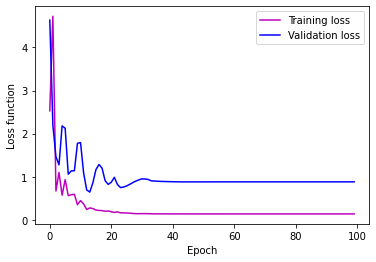

In [41]:
from IPython import embed
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(history.history['loss'],color='m',label='Training loss')
plt.plot(history.history['val_loss'],color='b',label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='upper right')
fig.savefig('training_validation.pdf')

#PlotHistory(loss_history,params=parameters)
# Params is a dict of parameters with name and values
# used for plotting


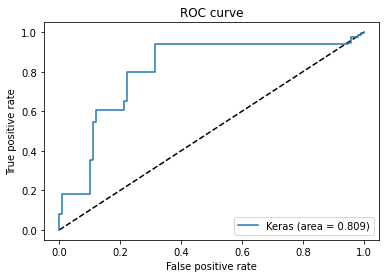

Threshold value is: 0.539368


In [42]:
prediction = model.predict(X_test)
from sklearn.metrics import roc_curve
import numpy as np
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, prediction,sample_weight=w_test)
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, prediction)

#with open('fpr.npy', 'wb') as f:
 #   np.save(f, np.array(fpr_keras))

#from roc import rocAndSig
#rocAndSig(y_test,prediction,w_test,'testflorian.pdf')


from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

from IPython import embed
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='XGBoost (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
fig.savefig("ROC_curve.pdf")
plt.show()
optimal_idx = np.argmax(tpr_keras - fpr_keras)
optimal_threshold = thresholds_keras[optimal_idx]
print("Threshold value is:", optimal_threshold)


14
296


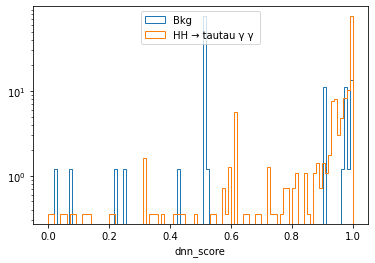

In [43]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(prediction[y_test==0],weights=w_test[y_test==0],histtype=("step"),bins=100,label='Bkg')
plt.hist(prediction[y_test==1],weights=w_test[y_test==1],histtype=("step"),bins=100,label='HH \u2192 tautau \u03B3 \u03B3 ')
plt.yscale('log') 
plt.xlabel('dnn_score')
#plt.ylabel('')
#plt.title('dnn_score')
plt.legend(loc='upper center')
fig.savefig("prediction.pdf", dpi = 300)
print(y_test[y_test==0].shape[0] )
print(y_test[y_test==1].shape[0])

In [44]:
# evaluate the model
scores = model.evaluate(X_test, y_test, sample_weight=w_test, verbose=2)
#scores = model.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

10/10 - 0s - loss: 0.8798 - binary_accuracy: 0.9000 - auc: 0.7114 - precision: 0.9682 - recall: 0.9257 - 36ms/epoch - 4ms/step
binary_accuracy: 90.00%


In [46]:
# save model and architecture to single file
model.save("model_dnn")
print("Saved model to disk")

INFO:tensorflow:Assets written to: model_dnn/assets
Saved model to disk
